In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)


/home/onizuka/Documents/Project M1/venv/bin/python3.10


In [3]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14',
       'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30',
       'Pct_Change', 'Log_Returns', 'Volatility_10', 'Volatility_30',
       'Future_Close', 'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [4]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [5]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [6]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [8]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8732, 15)
y_train shape: (8732,)


## LightGboost

from lightgbm import LGBMClassifier
from sklearn.base import is_classifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss instead of binary_error
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


## Hyperparameter

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


##  Rebuild the model with Hyperparameters 

# Train the model with the best parameters
best_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 2. XGBoost Model


import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50)  # Adjust n_trials for more or fewer experiments

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)


# Step 8: Evaluate the model on the test set
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Créer le modèle RandomForest
    model = RandomForestClassifier(**params, random_state=42)
    
    # Évaluation avec validation croisée
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss

# Étape d'optimisation avec Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

[I 2025-01-24 18:08:54,719] A new study created in memory with name: no-name-41a063df-4c87-4d4f-b251-28099377de49


[I 2025-01-24 18:09:01,967] Trial 0 finished with value: 6.116993577493714 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 6.116993577493714.


[I 2025-01-24 18:09:09,630] Trial 1 finished with value: 2.593499277577031 and parameters: {'n_estimators': 171, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 2.593499277577031.


[I 2025-01-24 18:09:11,656] Trial 2 finished with value: 1.2919208053194833 and parameters: {'n_estimators': 155, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:09:15,602] Trial 3 finished with value: 1.5864427729487363 and parameters: {'n_estimators': 163, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:09:40,268] Trial 4 finished with value: 13.282507804792203 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:09:43,662] Trial 5 finished with value: 2.912925981367109 and parameters: {'n_estimators': 103, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:10:23,011] Trial 6 finished with value: 15.946557022303441 and parameters: {'n_estimators': 190, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:10:50,214] Trial 7 finished with value: 18.327090768835454 and parameters: {'n_estimators': 116, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:10:58,613] Trial 8 finished with value: 4.444395002286757 and parameters: {'n_estimators': 167, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:11:02,535] Trial 9 finished with value: 3.3300266140248085 and parameters: {'n_estimators': 131, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 1.2919208053194833.


[I 2025-01-24 18:11:03,156] Trial 10 finished with value: 1.1076118916128053 and parameters: {'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 10 with value: 1.1076118916128053.


[I 2025-01-24 18:11:03,989] Trial 11 finished with value: 1.1041793267174345 and parameters: {'n_estimators': 68, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True}. Best is trial 11 with value: 1.1041793267174345.


[I 2025-01-24 18:11:05,277] Trial 12 finished with value: 2.599985962966138 and parameters: {'n_estimators': 58, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True}. Best is trial 11 with value: 1.1041793267174345.


[I 2025-01-24 18:11:05,918] Trial 13 finished with value: 1.1039666517631375 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:07,932] Trial 14 finished with value: 2.901347963218018 and parameters: {'n_estimators': 78, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:09,390] Trial 15 finished with value: 2.1407842137919193 and parameters: {'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:11,251] Trial 16 finished with value: 3.4335300869522527 and parameters: {'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:11,971] Trial 17 finished with value: 1.1113352807244279 and parameters: {'n_estimators': 64, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:14,551] Trial 18 finished with value: 3.189829687483777 and parameters: {'n_estimators': 93, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:16,490] Trial 19 finished with value: 2.5457498366905584 and parameters: {'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:18,471] Trial 20 finished with value: 1.480106860982045 and parameters: {'n_estimators': 116, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 1.1039666517631375.


[I 2025-01-24 18:11:19,111] Trial 21 finished with value: 1.099372831855951 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:19,755] Trial 22 finished with value: 1.1127027648793368 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:20,883] Trial 23 finished with value: 2.371341124783677 and parameters: {'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:22,273] Trial 24 finished with value: 2.8335080005515927 and parameters: {'n_estimators': 65, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:23,028] Trial 25 finished with value: 1.3080868228800384 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:25,123] Trial 26 finished with value: 3.162904149877266 and parameters: {'n_estimators': 81, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:26,327] Trial 27 finished with value: 1.6694452667751172 and parameters: {'n_estimators': 64, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:30,358] Trial 28 finished with value: 5.913459354273292 and parameters: {'n_estimators': 91, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:32,213] Trial 29 finished with value: 1.465243284033436 and parameters: {'n_estimators': 103, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:39,230] Trial 30 finished with value: 7.3443080166658365 and parameters: {'n_estimators': 69, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:39,953] Trial 31 finished with value: 1.3080868228800384 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:40,647] Trial 32 finished with value: 1.120496404384464 and parameters: {'n_estimators': 56, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:41,523] Trial 33 finished with value: 1.3433491535423507 and parameters: {'n_estimators': 61, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:42,821] Trial 34 finished with value: 2.4045211829235633 and parameters: {'n_estimators': 72, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:43,777] Trial 35 finished with value: 1.1556152204291812 and parameters: {'n_estimators': 58, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:46,671] Trial 36 finished with value: 2.1316908042049265 and parameters: {'n_estimators': 152, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:53,898] Trial 37 finished with value: 2.398083565449631 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:11:55,165] Trial 38 finished with value: 1.3070217474751389 and parameters: {'n_estimators': 84, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:01,689] Trial 39 finished with value: 10.779185434155986 and parameters: {'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_features': None, 'bootstrap': False}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:04,497] Trial 40 finished with value: 1.2975531942279026 and parameters: {'n_estimators': 199, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:05,333] Trial 41 finished with value: 1.1050053242933224 and parameters: {'n_estimators': 69, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:06,229] Trial 42 finished with value: 1.1013219486142567 and parameters: {'n_estimators': 72, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:07,900] Trial 43 finished with value: 1.3157895308306384 and parameters: {'n_estimators': 112, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:10,745] Trial 44 finished with value: 2.5139777743288874 and parameters: {'n_estimators': 97, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 1.099372831855951.


[I 2025-01-24 18:12:11,556] Trial 45 finished with value: 1.098341561968604 and parameters: {'n_estimators': 71, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 45 with value: 1.098341561968604.


[I 2025-01-24 18:12:20,330] Trial 46 finished with value: 8.699032280433677 and parameters: {'n_estimators': 85, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': None, 'bootstrap': False}. Best is trial 45 with value: 1.098341561968604.


[I 2025-01-24 18:12:23,479] Trial 47 finished with value: 3.726135371973787 and parameters: {'n_estimators': 133, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 45 with value: 1.098341561968604.


[I 2025-01-24 18:12:25,534] Trial 48 finished with value: 2.952940218493736 and parameters: {'n_estimators': 76, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 45 with value: 1.098341561968604.


[I 2025-01-24 18:12:26,261] Trial 49 finished with value: 1.1229792212524132 and parameters: {'n_estimators': 59, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True}. Best is trial 45 with value: 1.098341561968604.


In [10]:
# Récupérer les meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Ajouter les paramètres fixes nécessaires pour RandomForestClassifier
best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_leaf=12,
                       n_estimators=71, random_state=42)

In [11]:
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.43014200641319283

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.90      0.56       889
           1       0.61      0.11      0.18      1294

    accuracy                           0.43      2183
   macro avg       0.51      0.50      0.37      2183
weighted avg       0.53      0.43      0.34      2183



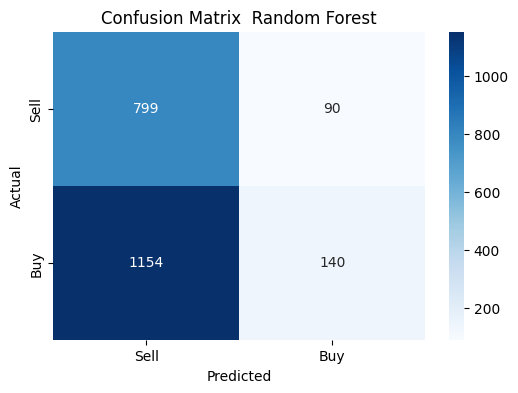

In [12]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Final Model (The best Model)

In [13]:
# Save the model for future use
joblib.dump(final_model, "random_forest_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [14]:
# Ensure that when saving predictions, we use the correct column names
predictions_df = pd.DataFrame({
    'Date': data.iloc[y_test.index]['Date'],  # Assuming there's a 'Date' column in your original data
    'Actual': y_test,
    'Predicted': y_pred
})

# Save predictions with the correct column names
predictions_path = 'data/final_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")


Predictions saved to data/final_predictions.csv
